# Dataset

In [1]:
import pandas as pd

rawData = pd.read_csv('https://raw.githubusercontent.com/skduong/anuran-calls/master/Frogs_MFCCs.csv')
data = rawData[rawData.columns[:23]] #focus on Family classification
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,MFCCs_11,MFCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,-0.075622,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,-0.095004,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,-0.072827,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,-0.162258,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,-0.100749,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae


# Preprocessing/ Rebalancing

In [2]:
import numpy as np
from imblearn.over_sampling import SMOTE

lepto = data.loc[data['Family'] == 'Leptodactylidae']
hyli = data.loc[data['Family'] == 'Hylidae']
dendro = data.loc[data['Family'] == 'Dendrobatidae']

#oversample dendro classes to match dendro
subset = pd.concat([hyli, dendro])
X = subset.drop(['Family'], 1)
y = subset['Family']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y) #X = data matrix, y = labels
oversample_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], 1)
oversample_df.columns = lepto.columns.values
#pd.Series(y).value_counts()

#randomly undersample lepto by 1420 cases
undersample = lepto.drop(np.random.choice(lepto.index, 1420, False))

#rebalanced data
data = pd.concat([undersample, oversample_df], ignore_index=True)
data['Family'].value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Leptodactylidae    3000
Hylidae            2165
Dendrobatidae      2165
Name: Family, dtype: int64

In [3]:
features = data[data.columns[:-1]].reset_index(drop=True)
labels = data['Family'].reset_index(drop=True)
#data.describe()

In [4]:
import numpy as np
import functools
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Train/Test Split

In [5]:
#create train/test set
train, test = train_test_split(data, test_size = 0.2, random_state = 0)

x_train = train.drop(['Family'], axis=1)
x_test = test.drop(['Family'], axis=1)

y_train = train['Family']
y_test = test['Family']

# Estimating Hidden Layer Sizes H*




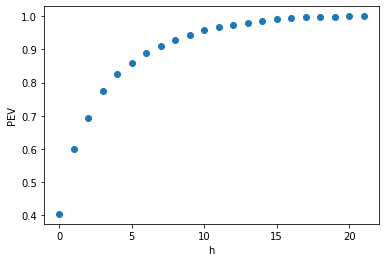

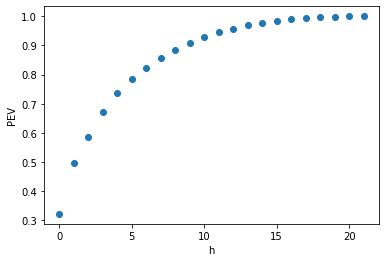

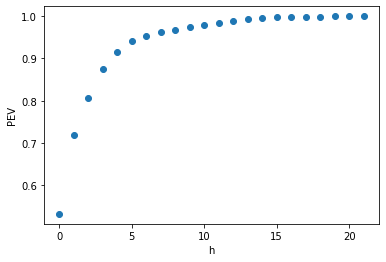

In [7]:
sfeatures = features.apply(lambda x: (x-x.mean())/x.std()) 
lepto = sfeatures.loc[data['Family'] == 'Leptodactylidae']
hyli = sfeatures.loc[data['Family'] == 'Hylidae']
dendro = sfeatures.loc[data['Family'] == 'Dendrobatidae']

#H*:
hi = []
for i in [lepto, hyli, dendro]:
  pca = PCA(n_components = 22)
  pca.fit_transform(i)
  pev = pca.explained_variance_ratio_.cumsum()
  hi.append(np.where(pev >= 0.99)[0][0]+1)
  plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('h'); plt.show() #plot PVE
  
h_star = sum(hi)

In [8]:
print('H*=',h_star)

H*= 48


# MLP

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
dense (Dense)                (None, 48)                1104      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 147       
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
MLP0:



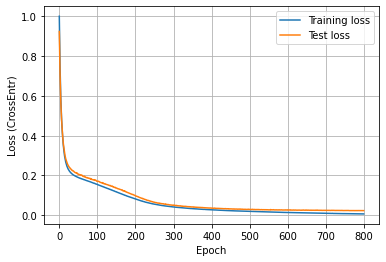

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import load_model
tf.get_logger().setLevel('ERROR') #surpress logging 

def plotPerf(monitor):
  plt.plot(monitor.model.history.history['loss'], label = 'Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label = 'Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def ypred(x, model):
  return list(map({0:'Deondrobatidae', 1:'Hylidae', 2:'Leptodactylidae'}.get, model.predict(x).argmax(axis = -1)))

def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name = 'Actual')
  y_pred = pd.Series(pred, name = 'Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

inputs = keras.Input(shape = (22,))
x1 = layers.Dense(h_star ,activation = "sigmoid")(inputs)
outputs = layers.Dense(3, activation = "softmax")(x1)
model0 = keras.Model(inputs = inputs,outputs = outputs)
model0.summary()

optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model0.compile(optimizer = optimizer,loss = loss_fn, metrics = ['accuracy'])
batch = round(len(train)**0.5)
Monitor0 = model0.fit(x_train, y_train.astype('category').cat.codes, epochs = 800, batch_size = batch,
                      validation_data = (x_test, y_test.astype('category').cat.codes), verbose = 0)

print('MLP0:\n')
plotPerf(Monitor0) #visually find stabT, overfitT, stopT

In [11]:
stabT = 400

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == stabT:
            self.model.save("modelh0_{}".format(epoch))

checkpoint = CustomSaver()
inputs = keras.Input(shape = (22,))
x1 = layers.Dense(h_star,activation = "sigmoid")(inputs)
outputs = layers.Dense(3, activation = "softmax")(x1)

model0 = keras.Model(inputs = inputs,outputs = outputs)
model0.compile(optimizer = optimizer, loss = loss_fn,  metrics = ['accuracy'])
model0.fit(x_train, y_train.astype('category').cat.codes, epochs = stabT+1, batch_size = batch,
                      validation_data = (x_test, y_test.astype('category').cat.codes), callbacks = [checkpoint], verbose = 0)

model0_stab = load_model("modelh0_{}".format(stabT))
trainConf0 = conf(y_train, ypred(x_train, model0_stab))
print('MLP0 train:\n', trainConf0)
testConf0 = conf(y_test, ypred(x_test, model0_stab))
print('\nMLP0 test:\n', testConf0)

MLP0 train:
 Predicted        Deondrobatidae   Hylidae  Leptodactylidae
Actual                                                    
Dendrobatidae          0.997662  0.001144         0.000000
Hylidae                0.000584  0.987993         0.005824
Leptodactylidae        0.001753  0.010863         0.994176

MLP0 test:
 Predicted        Deondrobatidae   Hylidae  Leptodactylidae
Actual                                                    
Dendrobatidae          0.995633  0.000000         0.000000
Hylidae                0.000000  0.983412         0.011945
Leptodactylidae        0.004367  0.016588         0.988055
